# pfs - probability of fault slip
## Worked Example 2 - Fracture susceptibility
First, some necessary loading of libraries. In addition to the standard Python set for numerical work, we need pfs.py and sga.py. 
pfs.py has definitions of all the functions that make up pfs. pfs.py imports sga.py, which has a Python implementation of selected functions converted from the MATLAB originals in Allmendiger et al. (2012) Structural Geology Algorithms.   

In [30]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import linalg
import pfs

Initialise some variables...

In [31]:
nMC = 5000          #   number of Monte Carlo runs 
nBins = 20          #   number of bins in histograms  

To calculate fracture susceptibility, $S_f$, we need the stress magnitudes, the azimuth of sHmax (assuming an Andersonian stress state, with one principal stress vertical), pore fluid pressure, the strike and dip of the fault plane, a coefficient of friction and the cohesive strength. Thus, q=9 variables in total.  

First up, we define the stress tensor. In this worked example, we'll use $\sigma_V, \sigma_H, \sigma_h$. We specify the mean and std dev of each normal distribution. The pfs function setStressDist() builds a consistent set of normally distributed stresses (of size $n_{MC}$), where $\sigma_1 >= \sigma_2 >= \sigma_3$. From these distributions, we get the min, max, mean, std dev and range for later use.   

In [32]:
#   sigma1 - most compressive, in MPa 
muSV = 75.
sdSV = muSV * .1 
#   sigma2 - intermediate, in MPa 
muSH = 55.
sdSH = muSH * .1
#   sigma3 - least compressive, in MPa 
muSh = 35.
sdSh = muSh * .1

stress = pfs.setStressDist(nMC, muSV, sdSV, muSH, sdSH, muSh, sdSh)
SV = stress[:,0]
SH = stress[:,1]
Sh = stress[:,2]

minSV = SV.min()
maxSV = SV.max()
meanSV = SV.mean()
stdSV = SV.std()
rangeSV = maxSV - minSV 

minSH = SH.min()
maxSH = SH.max()
meanSH = SH.mean()
stdSH = SH.std()
rangeSH = maxSH - minSH 

minSh = Sh.min()
maxSh = Sh.max()
meanSh = Sh.mean()
stdSh = Sh.std()
rangeSh = maxSh - minSh 

In contrast to slip or dilation tendency, we also need to define the in situ or ambient pore fluid pressure. A value of 30 MPa is reasonable for 3 km depth, assuming a hydrostatic gradient. 

In [33]:
#   pore fluid pressure; can assume hydrostatic in many cases (= 0.4 * sV)
muPf = 30.      #   hydrostatic 
sdPf = muPf * .1 
Pf = stats.norm.rvs(muPf, sdPf, nMC)
minPf = Pf.min()
maxPf = Pf.max()
meanPf = Pf.mean()
stdPf = Pf.std()
rangePf = maxPf - minPf 

Next, we define the orientation or azimuth of sHmax, in degrees from North. We use a von Mises - or circular normal - distribution. And we get the circular mean and std dev for later use. $\kappa$ is the dispersion parameter for a von Mises distribution (higher = less dispersed). Note that we 'correct' any azimuths outside the range of 0-180. 

In [34]:
#   SHmax azimuth
#   von Mises circular normal distribution 
SHazMean = 60.
SHazKappa = 200. 
#   von Mises symmetrical about mean, in range -pi to +pi
SHaz = pfs.rad2deg(np.random.vonmises(pfs.deg2rad(SHazMean), SHazKappa, nMC))
minSHaz, maxSHaz, meanSHaz, medianSHaz = pfs.getCircStats(SHaz) 
rangeSHaz = maxSHaz - np.abs(minSHaz) 
SHazTrue = SHaz
SHaz[np.ix_(SHaz<0)] += 180.
SHaz[np.ix_(SHaz>180)] -= 180.

Next up, we define the fault orientation and uncertainty thereof. And enforce a "right hand rule" convention: with the palm of your right hand on the fault plane and fingers pointing down dip, your right thumb points in the direction of strike. Again, we collect the stats for later use.     

In [35]:
#   fault strike, degrees 
#   von Mises circular normal distribution 
muStrike = 60.
kappaStrike = 200. 

#   fault dip, degrees 
#   von Mises circular normal distribution 
muDip = 60.
kappaDip = 200. 

#   rationalise the fault plane distribution to conform to right-hand rule 
#   strike < 180, dip component to South (dip always <= 90) 
#   strike > 180, dip component to North (dip always <= 90) 
Strike, StrikeTrue, Dip = pfs.setFaultDist(nMC, muStrike, kappaStrike, muDip, kappaDip)

minStrike, maxStrike, meanStrike, medianStrike = pfs.getCircStats(StrikeTrue) 
rangeStrike = StrikeTrue.max() - StrikeTrue.min() 

minDip, maxDip, meanDip, medianDip = pfs.getCircStats(Dip) 
rangeDip = maxDip - minDip 

Now we define the rock properties - friction and cohesion. In common with previous work, we will assume skew normal distributions for these (rather than symmetrical normal), with the friction skewed low (alpha < 0) and cohesion skewed high (alpha > 0). But these assumptions need further testing with laboratory data.  

In [36]:
#   rock properties - friction and cohesion 
muMu = 0.6 
sdMu = muMu * .2 
a = -3. 
Mu = stats.skewnorm.rvs(a, muMu, sdMu, nMC)
minMu = Mu.min()
maxMu = Mu.max()
rangeMu = maxMu - minMu 
meanMu = Mu.mean()
stdMu = Mu.std()

muC0 = 20. 
sdC0 = muC0 * .1
a = +3. 
C0 = stats.skewnorm.rvs(a, muC0, sdC0, nMC)
minC0 = C0.min()
maxC0 = C0.max()
rangeC0 = maxC0 - minC0 
meanC0 = C0.mean()
stdC0 = C0.std() 

As a useful cross check before we start calculating, let's plot the nine input variable distributions in histogram form...

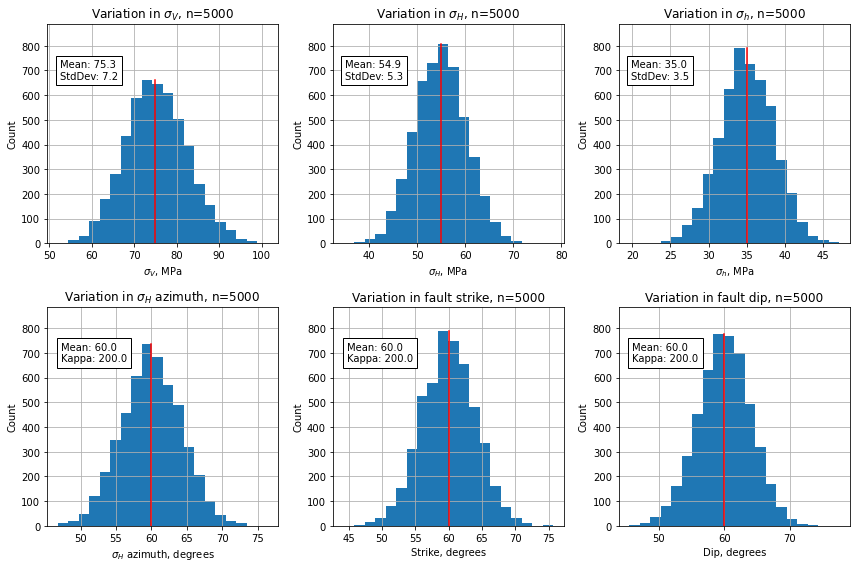

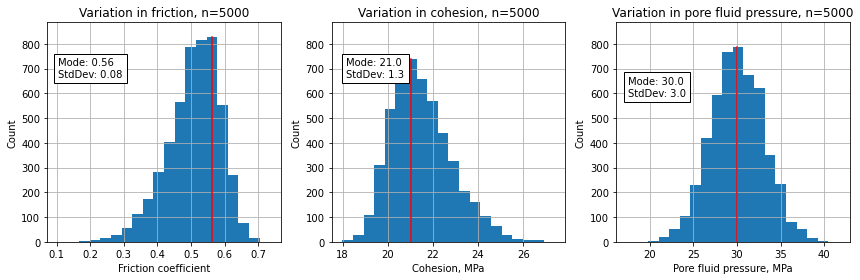

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(12,8))

nSV, bSV, pSV = axs[0,0].hist(SV, nBins)
nSH, bSH, pSH = axs[0,1].hist(SH, nBins)
nSh, bSh, pSh = axs[0,2].hist(Sh, nBins)
nSHaz, bSHaz, pSHaz = axs[1,0].hist(SHaz, nBins)
nStrike, bStrike, pStrike = axs[1,1].hist(Strike, nBins)
nDip, bDip, pDip = axs[1,2].hist(Dip, nBins)

nMax = np.max([nSh.max(), nSH.max(), nSV.max(), nSHaz.max(), nStrike.max(), nDip.max()])*1.1 

axs[0,0].plot([muSV, muSV], [0, np.max(nSV)], '-r')
axs[0,0].text(SV.min()*1.01, nMax*.75, 
              ('Mean: %3.1f\nStdDev: %2.1f' % (meanSV, stdSV)), 
                           bbox=dict(facecolor='white', edgecolor='black'))
axs[0,0].set_ylim(0., nMax)
axs[0,0].set_xlabel(r'$\sigma_V$, MPa')
axs[0,0].set_ylabel('Count')
axs[0,0].grid(True)
axs[0,0].set_title(r'Variation in $\sigma_V$, n=%i' % nMC)

axs[0,1].plot([muSH, muSH], [0, np.max(nSH)], '-r')
axs[0,1].text(SH.min()*1.01, nMax*.75, 
              ('Mean: %3.1f\nStdDev: %2.1f' % (meanSH, stdSH)),
                           bbox=dict(facecolor='white', edgecolor='black'))
axs[0,1].set_ylim(0., nMax)
axs[0,1].set_xlabel(r'$\sigma_H$, MPa')
axs[0,1].set_ylabel('Count')
axs[0,1].grid(True)
axs[0,1].set_title(r'Variation in $\sigma_H$, n=%i' % nMC)

axs[0,2].plot([muSh, muSh], [0, np.max(nSh)], '-r')
axs[0,2].text(Sh.min()*1.01, nMax*.75, 
              ('Mean: %3.1f\nStdDev: %2.1f' % (meanSh, stdSh)),
                           bbox=dict(facecolor='white', edgecolor='black'))
axs[0,2].set_ylim(0., nMax)
axs[0,2].set_xlabel(r'$\sigma_h$, MPa')
axs[0,2].set_ylabel('Count')
axs[0,2].grid(True)
axs[0,2].set_title(r'Variation in $\sigma_h$, n=%i' % nMC)

axs[1,0].plot([meanSHaz, meanSHaz], [0, np.max(nSHaz)], '-r')
axs[1,0].text(minSHaz*1.01, nMax*.75, 
              ('Mean: %3.1f\nKappa: %3.1f' % (meanSHaz, SHazKappa)),
                           bbox=dict(facecolor='white', edgecolor='black'))
axs[1,0].set_ylim(0., nMax)
axs[1,0].set_xlabel(r'$\sigma_H$ azimuth, degrees')
axs[1,0].set_ylabel('Count')
#axs[1,0].set_xlim(0., 180.)
axs[1,0].grid(True)
axs[1,0].set_title(r'Variation in $\sigma_H$ azimuth, n=%i' % nMC)

axs[1,1].plot([meanStrike, meanStrike], [0, np.max(nStrike)], '-r')
axs[1,1].text(minStrike*1.01, nMax*.75, 
              ('Mean: %3.1f\nKappa: %3.1f' % (muStrike, kappaStrike)),
                           bbox=dict(facecolor='white', edgecolor='black'))
axs[1,1].set_ylim(0., nMax)
axs[1,1].set_xlabel('Strike, degrees')
axs[1,1].set_ylabel('Count')
#axs[1,1].set_xlim(0., 360.)
axs[1,1].grid(True)
axs[1,1].set_title('Variation in fault strike, n=%i' % nMC)

axs[1,2].plot([meanDip, meanDip], [0, np.max(nDip)], '-r')
axs[1,2].text(minDip*1.01, nMax*.75, 
              ('Mean: %3.1f\nKappa: %3.1f' % (muDip, kappaDip)),
                           bbox=dict(facecolor='white', edgecolor='black'))
axs[1,2].set_ylim(0., nMax)
axs[1,2].set_xlabel('Dip, degrees')
axs[1,2].set_ylabel('Count')
#axs[1,2].set_xlim(0., 90.)
axs[1,2].grid(True)
axs[1,2].set_title('Variation in fault dip, n=%i' % nMC)

plt.tight_layout() 
plt.savefig('WorkedExample2_input_hist1.png', dpi=300)

fig, axs = plt.subplots(1, 3, figsize=(12,4))

nMu, bMu, pMu = axs[0].hist(Mu, nBins)
nC0, bC0, pC0 = axs[1].hist(C0, nBins)
nPf, bPf, pPf = axs[2].hist(Pf, nBins)

#   get mode of mu and C0 as better measures of distrib 
modeMu = bMu[np.ix_(nMu == nMu.max())] + (bMu[1]-bMu[0])/2.
modeC0 = bC0[np.ix_(nC0 == nC0.max())] + (bC0[1]-bC0[0])/2.

axs[0].plot([modeMu, modeMu], [0, np.max(nMu)], '-r')
axs[0].text(minMu*1.01, nMax*.75, 
              ('Mode: %3.2f\nStdDev: %3.2f' % (modeMu, stdMu)),
                           bbox=dict(facecolor='white', edgecolor='black'))
axs[0].set_ylim(0., nMax)
axs[0].set_xlabel('Friction coefficient')
axs[0].set_ylabel('Count')
axs[0].grid(True)
axs[0].set_title('Variation in friction, n=%i' % nMC)

axs[1].plot([modeC0, modeC0], [0, np.max(nC0)], '-r')
axs[1].text(minC0*1.01, nMax*.75, 
              ('Mode: %3.1f\nStdDev: %3.1f' % (modeC0, stdC0)),
                           bbox=dict(facecolor='white', edgecolor='black'))
axs[1].set_ylim(0., nMax)
axs[1].set_xlabel('Cohesion, MPa')
axs[1].set_ylabel('Count')
axs[1].grid(True)
axs[1].set_title('Variation in cohesion, n=%i' % nMC)

axs[2].plot([muPf, muPf], [0, np.max(nPf)], '-r')
axs[2].text(minPf*1.01, nPf.max()*.75, 
              ('Mode: %3.1f\nStdDev: %3.1f' % (muPf, stdPf)),
                           bbox=dict(facecolor='white', edgecolor='black'))
axs[2].set_ylim(0., nMax)
axs[2].set_xlabel('Pore fluid pressure, MPa')
axs[2].set_ylabel('Count')
axs[2].grid(True)
axs[2].set_title('Variation in pore fluid pressure, n=%i' % nMC)

plt.tight_layout() 
plt.savefig('WorkedExample2_input_hist2.png', dpi=300)

Too easy. 

Also, we can plot a Mohr diagram to visualise the key issue: given the known variations in stress, pressure etc (as specified through the std devs used in their normal distributions), what is the probability that any of the stress states will exceed the Mohr-Coulomb failure criterion? 

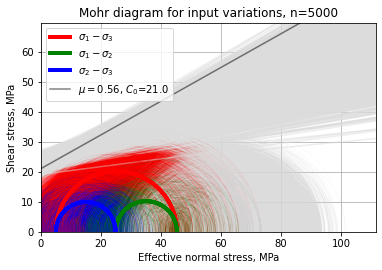

In [38]:
#   Mohr plot showing variations in stresses 
pfs.plotMohr4(SV, SH, Sh, Pf, Mu, modeMu, C0, modeC0)

The mean value of the max. differential stress ($\sigma_D$ = $\sigma_1$-$\sigma_3$) is shown in red, and the variations shown in grey. 

Q: How many of those grey stress states cut the M-C failure line? 

We'll use a Response Surface approach, combined with a Monte Carlo simulation to produce a statistically viable set of predictions from which we can infer the probability of slip. 

## Quadratic response surface for fracture susceptibility
We will solve the system of equations for $$y = \beta X_q$$ for $\beta_q$, the vector of coefficients of the Response Surface. 

The number of variables, $q$, is 9. $y$ is a vector of "responses" (in our case, for $S_f$), and $X_q$ is a matrix of coded variables, one for each of the inputs defined above. 

To define the response surface, we only use the min, max and mean of each input variable, in a so-called $3^q$ sample design. As such, the values in $X_q$ are set to -1 (min), 0 (mean) and +1 (max). Each row in $X_q$ is for a different permutation of the 9 input variables values, and each column is for a different variable. 

In [39]:
q = 9                  #   9 variables, linear terms only 
q2 = 0.5 * q * (q + 1) + q  #   total terms incl. squares and products 

nSf = pow(3,q)         #   3 coordinates for each variable 

Xl = np.zeros([nSf,q+1])
Xq = np.zeros([int(nSf), int(q2)+1])

#    first, build the linear terms... 
iRow = 0 
for iA in range(-1,+2):
    for iB in range(-1,+2):
        for iC in range(-1,+2):
            for iD in range(-1,+2):
                for iE in range(-1,+2):
                    for iF in range(-1,+2):
                        for iG in range(-1,+2):
                            for iH in range(-1,+2):
                                for iJ in range(-1,+2):
                                    Xl[iRow, :] = [1, iA, iB, iC, iD, iE, iF, iG, iH, iJ]
                                    iRow += 1

#   get y values for Sf 
ySf = np.zeros([nSf,])
for i in range(0,nSf):
    ySV = Xl[i,1] * rangeSV / 2. + meanSV 
    ySH = Xl[i,2] * rangeSH / 2. + meanSH 
    ySh = Xl[i,3] * rangeSh / 2. + meanSh 
    yPf = Xl[i,4] * rangePf / 2. + meanPf
    ySHaz = Xl[i,5] * rangeSHaz / 2. + meanSHaz 
    if ySHaz < 0.:
        ySHaz += 180.
    yStrike = Xl[i,6] * rangeStrike / 2. + meanStrike 
    if yStrike < 0.:
        yStrike += 360.
    yDip = Xl[i,7] * rangeDip / 2. + meanDip 
    yMu = Xl[i,8] * rangeMu / 2. + meanMu 
    yC0 = Xl[i,9] * rangeC0 / 2. + meanC0 
    ysigmaN, ytau = pfs.calcAndersonianStressOnPlane(ySV, ySH, ySh, ySHaz, yStrike, yDip) 
    ySf[i] = (ysigmaN - yPf) - (ytau - yC0) / yMu 

#   and then the quadratic terms, using the linear terms from above 
for iQ in range(0,nSf):
    #   linear terms 
    Xq[iQ,1] = Xl[iQ,1]
    Xq[iQ,2] = Xl[iQ,2]
    Xq[iQ,3] = Xl[iQ,3]
    Xq[iQ,4] = Xl[iQ,4]
    Xq[iQ,5] = Xl[iQ,5]
    Xq[iQ,6] = Xl[iQ,6]
    Xq[iQ,7] = Xl[iQ,7]
    Xq[iQ,8] = Xl[iQ,8]
    Xq[iQ,9] = Xl[iQ,9]
    
    #   cross products 
    Xq[iQ,10] = Xl[iQ,1]*Xl[iQ,2]
    Xq[iQ,11] = Xl[iQ,1]*Xl[iQ,3]
    Xq[iQ,12] = Xl[iQ,1]*Xl[iQ,4]
    Xq[iQ,13] = Xl[iQ,1]*Xl[iQ,5]
    Xq[iQ,14] = Xl[iQ,1]*Xl[iQ,6]
    Xq[iQ,15] = Xl[iQ,1]*Xl[iQ,7]
    Xq[iQ,16] = Xl[iQ,1]*Xl[iQ,8]
    Xq[iQ,17] = Xl[iQ,1]*Xl[iQ,9]
    
    Xq[iQ,18] = Xl[iQ,2]*Xl[iQ,3]
    Xq[iQ,19] = Xl[iQ,2]*Xl[iQ,4]
    Xq[iQ,20] = Xl[iQ,2]*Xl[iQ,5]
    Xq[iQ,21] = Xl[iQ,2]*Xl[iQ,6]
    Xq[iQ,22] = Xl[iQ,2]*Xl[iQ,7]
    Xq[iQ,23] = Xl[iQ,2]*Xl[iQ,8]
    Xq[iQ,24] = Xl[iQ,2]*Xl[iQ,9]
    
    Xq[iQ,25] = Xl[iQ,3]*Xl[iQ,4]
    Xq[iQ,26] = Xl[iQ,3]*Xl[iQ,5]
    Xq[iQ,27] = Xl[iQ,3]*Xl[iQ,6]
    Xq[iQ,28] = Xl[iQ,3]*Xl[iQ,7]
    Xq[iQ,29] = Xl[iQ,3]*Xl[iQ,8]
    Xq[iQ,30] = Xl[iQ,3]*Xl[iQ,9]
    
    Xq[iQ,31] = Xl[iQ,4]*Xl[iQ,5]
    Xq[iQ,32] = Xl[iQ,4]*Xl[iQ,6]
    Xq[iQ,33] = Xl[iQ,4]*Xl[iQ,7]
    Xq[iQ,34] = Xl[iQ,4]*Xl[iQ,8]
    Xq[iQ,35] = Xl[iQ,4]*Xl[iQ,8]
    
    Xq[iQ,36] = Xl[iQ,5]*Xl[iQ,6]
    Xq[iQ,37] = Xl[iQ,5]*Xl[iQ,7]
    Xq[iQ,38] = Xl[iQ,5]*Xl[iQ,8]
    Xq[iQ,39] = Xl[iQ,5]*Xl[iQ,9]
    
    Xq[iQ,40] = Xl[iQ,6]*Xl[iQ,7]
    Xq[iQ,41] = Xl[iQ,6]*Xl[iQ,8]
    Xq[iQ,42] = Xl[iQ,6]*Xl[iQ,9]
    
    Xq[iQ,43] = Xl[iQ,7]*Xl[iQ,8]
    Xq[iQ,44] = Xl[iQ,7]*Xl[iQ,9]

    Xq[iQ,45] = Xl[iQ,8]*Xl[iQ,9]
    
    #   squares 
    Xq[iQ,46] = Xl[iQ,1]*Xl[iQ,1]
    Xq[iQ,47] = Xl[iQ,2]*Xl[iQ,2]
    Xq[iQ,48] = Xl[iQ,3]*Xl[iQ,3]
    Xq[iQ,49] = Xl[iQ,4]*Xl[iQ,4]
    Xq[iQ,50] = Xl[iQ,5]*Xl[iQ,5]
    Xq[iQ,51] = Xl[iQ,6]*Xl[iQ,6]
    Xq[iQ,52] = Xl[iQ,7]*Xl[iQ,7]
    Xq[iQ,53] = Xl[iQ,8]*Xl[iQ,8]
    Xq[iQ,54] = Xl[iQ,9]*Xl[iQ,9]

Xq[:,0] = 1 
Xq2 = np.dot(Xq.T, Xq)  

#   get y values for quadratic terms... 
ySfq = np.zeros([int(q2)+1,])
for i in range(0, int(q2)+1):
    for j in range(0, nSf):
        ySfq[i] = ySfq[i] + Xq[j,i] * ySf[j] 
ySfq[0] = sum(ySf)

And now just least squares using the new $X$ and the new $y$ to get quadratic $\beta$...

In [40]:
#   solve for beta using least squares 
BetaSf, res, rank, s = linalg.lstsq(Xq2, ySfq)

Now we have defined a response surfaces $S_f$ to the min, mean and max of the input variable distributions, we can now run Monte Carlo simulations over the whole distribution of each variable (e.g., for $n_{MC}$ = 5000, or whatever), and get a statistically viable ensemble of predictions to help us with the probability. 

Remember that the $\beta$ coefficients defining the response surfaces were for coded for scaled variables; so we need to scale back to 'real' values for use in the Monte Carlo simulation.

In [41]:
#   Monte Carlo simulation using quadratic response surface 
mcSfq = np.zeros([nMC,])
xSV = (SV - meanSV) / (rangeSV / 2.)  
xSH = (SH - meanSH) / (rangeSH / 2.)  
xSh = (Sh - meanSh) / (rangeSh / 2.)  
xPf = (Pf - meanPf) / (rangePf / 2.)  
xSHaz = (SHazTrue - meanSHaz) / (rangeSHaz / 2.)  
xStrike = (StrikeTrue - meanStrike) / (rangeStrike / 2.)  
xDip = (Dip - meanDip) / (rangeDip / 2.)  
xMu = (Mu - meanMu) / (rangeMu / 2.)  
xC0 = (C0 - meanC0) / (rangeC0 / 2.)  
for i in range(0, nMC):
    mcSfq[i] = (BetaSf[0] + 
            BetaSf[1] * xSV[i] +
            BetaSf[2] * xSH[i] +
            BetaSf[3] * xSh[i] +
            BetaSf[4] * xPf[i] +
            BetaSf[5] * xSHaz[i] +
            BetaSf[6] * xStrike[i] +
            BetaSf[7] * xDip[i] +
            BetaSf[8] * xMu[i] +
            BetaSf[9] * xC0[i] +
            
            BetaSf[10] * xSV[i] * xSH[i] + 
            BetaSf[11] * xSV[i] * xSh[i] + 
            BetaSf[12] * xSV[i] * xPf[i] + 
            BetaSf[13] * xSV[i] * xSHaz[i] + 
            BetaSf[14] * xSV[i] * xStrike[i] + 
            BetaSf[15] * xSV[i] * xDip[i] + 
            BetaSf[16] * xSV[i] * xMu[i] + 
            BetaSf[17] * xSV[i] * xC0[i] + 
            
            BetaSf[18] * xSH[i] * xSh[i] + 
            BetaSf[19] * xSH[i] * xPf[i] + 
            BetaSf[20] * xSH[i] * xSHaz[i] + 
            BetaSf[21] * xSH[i] * xStrike[i] + 
            BetaSf[22] * xSH[i] * xDip[i] + 
            BetaSf[23] * xSH[i] * xMu[i] + 
            BetaSf[24] * xSH[i] * xC0[i] + 
            
            BetaSf[25] * xSh[i] * xPf[i] + 
            BetaSf[26] * xSh[i] * xSHaz[i] + 
            BetaSf[27] * xSh[i] * xStrike[i] + 
            BetaSf[28] * xSh[i] * xDip[i] + 
            BetaSf[29] * xSh[i] * xMu[i] + 
            BetaSf[30] * xSh[i] * xC0[i] + 
            
            BetaSf[31] * xPf[i] * xSHaz[i] + 
            BetaSf[32] * xPf[i] * xStrike[i] + 
            BetaSf[33] * xPf[i] * xDip[i] + 
            BetaSf[34] * xPf[i] * xMu[i] + 
            BetaSf[35] * xPf[i] * xC0[i] + 

            BetaSf[36] * xSHaz[i] * xStrike[i] + 
            BetaSf[37] * xSHaz[i] * xDip[i] + 
            BetaSf[38] * xSHaz[i] * xMu[i] + 
            BetaSf[39] * xSHaz[i] * xC0[i] + 
            
            BetaSf[40] * xStrike[i] * xDip[i] + 
            BetaSf[41] * xStrike[i] * xMu[i] + 
            BetaSf[42] * xStrike[i] * xC0[i] + 
            
            BetaSf[43] * xDip[i] * xMu[i] + 
            BetaSf[44] * xDip[i] * xC0[i] + 
            
            BetaSf[45] * xMu[i] * xC0[i] + 
            
            BetaSf[46] * xSV[i] * xSV[i] + 
            BetaSf[47] * xSH[i] * xSH[i] + 
            BetaSf[48] * xSh[i] * xSh[i] + 
            BetaSf[49] * xPf[i] * xPf[i] + 
            BetaSf[50] * xSHaz[i] * xSHaz[i] + 
            BetaSf[51] * xStrike[i] * xStrike[i] + 
            BetaSf[52] * xDip[i] * xDip[i] +
            BetaSf[53] * xMu[i] * xMu[i] +
            BetaSf[54] * xC0[i] * xC0[i])

Now we've done the hard work, we can visualise the results. A histogram and a CDF is a good place to start...

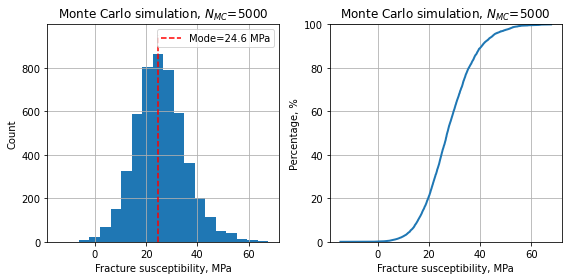

In [42]:
#   plot MC results    
fig, ax = plt.subplots(figsize=(8,4))

#   histogram
ax = plt.subplot(121)
n, b, p = ax.hist(mcSfq.T, nBins)
sortedb = b[n.argsort()]
incb = b[1] - b[0]
mcSfqMode = sortedb[-1] + incb/2. 
ax.plot([mcSfqMode, mcSfqMode], [0, np.max(n)*1.1], 
            '--r', label='Mode=%3.1f MPa' % mcSfqMode)
ax.grid(True)
ax.set_xlabel('Fracture susceptibility, MPa')
ax.set_ylabel('Count')
ax.legend()
ax.set_title(r'Monte Carlo simulation, $N_{MC}$=%i' % nMC)
        
#   CDF plot
ax = plt.subplot(122)
sortSf = np.sort(mcSfq)
#    cumSf = (np.cumsum(sortSf) / np.sum(sortSf)) * 100.
sortSfadj = sortSf - sortSf.min()
cumSf = (np.cumsum(sortSfadj) / np.sum(sortSfadj)) * 100.

ax.plot(sortSf, cumSf, linewidth=2)         
ax.grid(True)
ax.set_ylim(0., 100.) 
ax.set_xlabel('Fracture susceptibility, MPa')
ax.set_ylabel('Percentage, %')
ax.set_title(r'Monte Carlo simulation, $N_{MC}$=%i' % nMC)

plt.tight_layout()     
plt.savefig('WorkedExample2_quadratic_MChistCDF.png', dpi=300)

Finally, we can re-visit our input variable distributions plotted as histograms, and overlay the response surface calculated for that variable holding all the other variables at their mean values. These can be considered as 'sections' through the multivariate response surface (visualising a 9-dimensional surface is non-trivial!). 

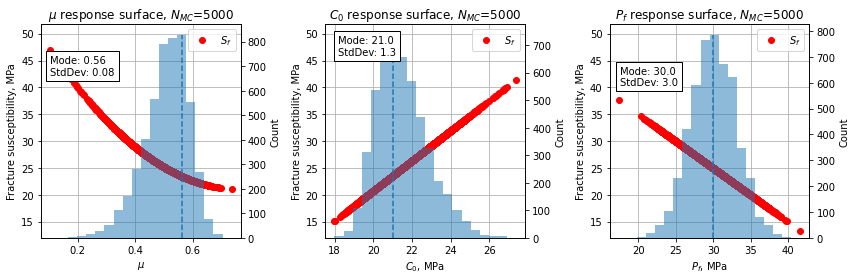

In [43]:
#   plot input distribution histograms with response surfaces 
#   overlain calculated for mean values of all other params 
sVSfq = np.zeros([nMC,])
sHSfq = np.zeros([nMC,])
shSfq = np.zeros([nMC,])
sHazSfq = np.zeros([nMC,])
strikeSfq = np.zeros([nMC,])
dipSfq = np.zeros([nMC,])
muSfq = np.zeros([nMC,])
c0Sfq = np.zeros([nMC,])
PfSfq = np.zeros([nMC,])
for i in range(0, nMC):
    
    sVSfq[i] = (BetaSf[0] + 
                BetaSf[1] * xSV[i] +
                BetaSf[46] * xSV[i] * xSV[i])

    sHSfq[i] = (BetaSf[0] + 
                BetaSf[2] * xSH[i] +
                BetaSf[47] * xSH[i] * xSH[i])

    shSfq[i] = (BetaSf[0] + 
                BetaSf[3] * xSh[i] +
                BetaSf[48] * xSh[i] * xSh[i])

    PfSfq[i] = (BetaSf[0] + 
                BetaSf[4] * xPf[i] +
                BetaSf[49] * xPf[i] * xPf[i])

    sHazSfq[i] = (BetaSf[0] + 
                  BetaSf[5] * xSHaz[i] +
                  BetaSf[50] * xSHaz[i] * xSHaz[i])

    strikeSfq[i] = (BetaSf[0] + 
                    BetaSf[6] * xStrike[i] +
                    BetaSf[51] * xStrike[i] * xStrike[i])

    dipSfq[i] = (BetaSf[0] + 
                 BetaSf[7] * xDip[i] +
                 BetaSf[52] * xDip[i] * xDip[i])

    muSfq[i] = (BetaSf[0] + 
                BetaSf[8] * xMu[i] +
                BetaSf[53] * xMu[i] * xMu[i])

    c0Sfq[i] = (BetaSf[0] + 
                BetaSf[9] * xC0[i] +
                BetaSf[54] * xC0[i] * xC0[i])

minSf = np.min([muSfq.min(), c0Sfq.min(), PfSfq.min()])*0.9
maxSf = np.max([muSfq.max(), c0Sfq.max(), PfSfq.max()])*1.1

fig, ax = plt.subplots(figsize=(12,4))

ax1a = plt.subplot(131)
ax1b = ax1a.twinx()
ax1b.hist(Mu, nBins, alpha=0.5)
ax1b.plot([modeMu, modeMu], [0, np.max(nMu)], '--C0')
ax1b.text(minMu*1.01, nMax*.75, 
              ('Mode: %3.2f\nStdDev: %3.2f' % (modeMu, stdMu)),
                           bbox=dict(facecolor='white', edgecolor='black'))
ax1b.set_ylabel('Count')
ax1a.plot(Mu, muSfq, 'or', linewidth=2, label='$S_f$')
ax1a.grid(True)
ax1a.set_xlabel(r'$\mu$')
ax1a.set_ylabel('Fracture susceptibility, MPa')
ax1a.set_ylim(minSf, maxSf)
ax1a.legend()
ax1a.set_title(r'$\mu$ response surface, $N_{MC}$=%i' % nMC)

ax2a = plt.subplot(132)
ax2b = ax2a.twinx()
ax2b.hist(C0, nBins, alpha=0.5)
ax2b.plot([modeC0, modeC0], [0, np.max(nC0)], '--C0')
ax2b.text(minC0*1.01, nMax*.75, 
              ('Mode: %3.1f\nStdDev: %3.1f' % (modeC0, stdC0)),
                           bbox=dict(facecolor='white', edgecolor='black'))
ax2b.set_ylabel('Count')
ax2a.plot(C0, c0Sfq, 'or', linewidth=2, label='$S_f$')
ax2a.grid(True)
ax2a.set_xlabel(r'$C_0$, MPa')
ax2a.set_ylabel('Fracture susceptibility, MPa')
ax2a.set_ylim(minSf, maxSf)
ax2a.legend()
ax2a.set_title(r'$C_0$ response surface, $N_{MC}$=%i' % nMC)

ax3a = plt.subplot(133)
ax3b = ax3a.twinx()
ax3b.hist(Pf, nBins, alpha=0.5)
ax3b.plot([muPf, muPf], [0, np.max(nPf)], '--C0')
ax3b.text(minPf*1.01, nPf.max()*.75, 
              ('Mode: %3.1f\nStdDev: %3.1f' % (muPf, stdPf)),
                           bbox=dict(facecolor='white', edgecolor='black'))
ax3b.set_ylabel('Count')
ax3a.plot(Pf, PfSfq, 'or', linewidth=2, label='$S_f$')
ax3a.grid(True)
ax3a.set_xlabel(r'$P_f$, MPa')
ax3a.set_ylabel('Fracture susceptibility, MPa')
ax3a.set_ylim(minSf, maxSf)
ax3a.legend()
ax3a.set_title(r'$P_f$ response surface, $N_{MC}$=%i' % nMC)

plt.tight_layout()     
plt.savefig('WorkedExample2_synthetic_respsurf.png', dpi=300)

Here is a tornado plot, showing the relative sensitivity of $S_f$ to each variable, ranked from highest to lowest:

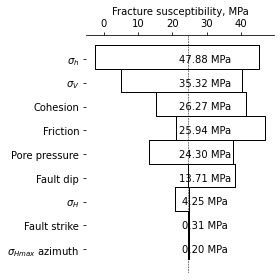

In [44]:
#   tornado plot of relative sensitivities
varNames = [r'$\sigma_V$', r'$\sigma_H$', r'$\sigma_h$', 
            r'$\sigma_{Hmax}$ azimuth', 'Fault strike', 'Fault dip',
            'Friction', 'Cohesion', 'Pore pressure']
lowSf = np.array([sVSfq.min(), sHSfq.min(), shSfq.min(), 
         sHazSfq.min(), strikeSfq.min(), 
         dipSfq.min(), muSfq.min(), c0Sfq.min(), PfSfq.min()])
highSf = np.array([sVSfq.max(), sHSfq.max(), shSfq.max(), 
          sHazSfq.max(), strikeSfq.max(), 
          dipSfq.max(), muSfq.max(), c0Sfq.max(), PfSfq.max()])
pfs.plotTornadoSf(lowSf, highSf, varNames, mcSfqMode)

There it is. Response Surface Methodology and Monte Carlo simulation applied to the calculation of probability for fracture susceptibility. 

Dave Healy 
July 2021 